Import Statments and Parameters:

--------------------------------------------------------------------

IMPORTANT: Run these pip installs,

If using miniconda: ```conda create --name project_env python=3.11```

```pip install tensorflow keras numpy pandas requests Pillow scikit-learn matplotlib opencv-python jupyter ipykernel```

Download dataset here: https://iris.di.ubi.pt/ubipr.html (Original version, Change DATASET_PATH accordingly)

--------------------------------------------------------------------

`IMG_SIZE` - All Images scaled to this size.

`BATCH_SIZE` - Groups pairs of images for siamese training.

In [1]:
from lib import *


# -----------------------------
# PARAMETERS
# -----------------------------
IMG_SIZE = (105, 105)
BATCH_SIZE = 32
EPOCHS = 4  # increase for better results
STEPS_PER_EPOCH = 50
# -----------------------------

env = load_env("paths.env")

base_cnn = create_base_cnn((*IMG_SIZE, 3))

if env is not None:
    DATASET_PATH, SAVE_PATH, GALLERY_PATH, QUERY_IMAGE_PATH, TEST_IMAGE_PATH = build_paths(env)

print("DATASET_PATH:", DATASET_PATH)
print("SAVE_PATH:", SAVE_PATH)
print("GALLERY_PATH:", GALLERY_PATH)
print("QUERY_IMAGE_PATH:", QUERY_IMAGE_PATH)
print("TEST_IMAGE_PATH:", TEST_IMAGE_PATH)


DATASET_PATH: C:\Users\Chase\OneDrive\Desktop\Courses\AI\AiFinalProject\AiFinalProject\UBIPeriocular
SAVE_PATH: C:\Users\Chase\OneDrive\Desktop\Courses\AI\AiFinalProject\AiFinalProject\siamese_eye_model.keras
GALLERY_PATH: C:\Users\Chase\OneDrive\Desktop\Courses\AI\AiFinalProject\AiFinalProject\Gallery
QUERY_IMAGE_PATH: C:\Users\Chase\OneDrive\Desktop\Courses\AI\AiFinalProject\AiFinalProject\query_image.jpg
TEST_IMAGE_PATH: C:\Users\Chase\OneDrive\Desktop\Courses\AI\AiFinalProject\AiFinalProject\TestImages


Image Preparation: Generates tensorflow dataset for training.  (Only use if new data has been added to training data, otherwise at next cell)

In [11]:
# -----------------------------
# IMAGE PREPARATION
# -----------------------------

images_dict = load_images_by_filename(DATASET_PATH, IMG_SIZE)
for person, imgs in images_dict.items():
    print(person, len(imgs))  # sanity check

train_ds = make_tf_dataset(images_dict, BATCH_SIZE, IMG_SIZE)

KeyboardInterrupt: 

Saves preprocessed images

In [10]:
save_path = os.path.join(os.getcwd(), "images_dict.npy")
np.save(save_path, images_dict)
print(f"Saved to {save_path}")

Saved to c:\Users\Chase\OneDrive\Desktop\Courses\AI\AiFinalProject\AiFinalProject\images_dict.npy


Loads preprocessed images and creates dataset

In [4]:
save_path = os.path.join(os.getcwd(), "images_dict.npy")
loaded_images_dict = np.load(save_path, allow_pickle=True).item()
for person, imgs in loaded_images_dict.items():
    print(person, len(imgs))  # sanity check

train_ds = make_tf_dataset(loaded_images_dict, BATCH_SIZE, IMG_SIZE)

C100_S1 15
C100_S2 15
C101_S1 15
C101_S2 14
C102_S1 15
C102_S2 15
C103_S1 15
C103_S2 15
C104_S1 15
C104_S2 15
C105_S1 15
C105_S2 15
C106_S1 15
C106_S2 15
C107_S1 15
C107_S2 15
C108_S1 15
C108_S2 15
C109_S1 15
C109_S2 15
C10_S1 15
C10_S2 15
C110_S1 15
C110_S2 15
C111_S1 15
C111_S2 15
C112_S1 15
C112_S2 15
C113_S1 15
C114_S1 15
C115_S1 14
C116_S1 14
C117_S1 15
C118_S1 15
C119_S1 12
C11_S1 15
C120_S1 14
C121_S1 15
C121_S2 15
C122_S1 15
C122_S2 15
C123_S1 14
C124_S1 14
C125_S1 15
C125_S2 15
C126_S1 15
C126_S2 15
C127_S1 15
C127_S2 15
C128_S1 15
C128_S2 15
C129_S1 15
C12_S1 15
C130_S1 15
C131_S1 15
C132_S1 15
C133_S1 15
C134_S1 15
C135_S1 15
C136_S1 15
C137_S1 15
C138_S1 15
C139_S1 15
C13_S1 15
C140_S1 15
C141_S1 15
C142_S1 15
C143_S1 15
C144_S1 15
C145_S1 15
C146_S1 15
C147_S1 9
C147_S2 14
C148_S1 12
C148_S2 12
C149_S1 15
C149_S2 15
C14_S1 15
C150_S1 15
C150_S2 15
C151_S1 15
C151_S2 15
C152_S1 15
C152_S2 15
C153_S1 15
C154_S1 15
C155_S1 15
C156_S1 15
C157_S1 14
C158_S1 13
C159_S1 15
C15_S1

Training:

In [12]:
# -----------------------------
# TRAINING
# -----------------------------
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

early_stop = EarlyStopping(
    monitor='loss',        # or 'val_loss' if using validation
    patience=5,            # stop after 5 epochs with no improvement
    restore_best_weights=True
)

model, base_cnn = create_siamese_model(input_shape=(*IMG_SIZE, 3))
model.compile(loss=contrastive_loss,
              optimizer=Adam(learning_rate=1e-4),
              metrics=[siamese_accuracy])
model.summary()

model.fit(
    train_ds,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_4        │ (None, 4096)      │ 38,960,448 │ input_layer_6[0]… │
│ (Functional)        │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1)         │          0 │ functional_4[0][… │
│                     │                   │            │ functional_4[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - loss: 0.2263 - siamese_accuracy: 0.6306
Epoch 2/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - loss: 0.1804 - siamese_accuracy: 0.7381
Epoch 3/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - loss: 0.1665 - siamese_accuracy: 0.7775
Epoch 4/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - loss: 0.1631 - siamese_accuracy: 0.7837


In [13]:
# Call this after training:
save_siamese_model(model, str(SAVE_PATH))  # Or a folder name

Model saved to: C:\Users\Chase\OneDrive\Desktop\Courses\AI\AiFinalProject\AiFinalProject\siamese_eye_model.keras


In [3]:
crop_gallery_images("Gallery", detect_eye, img_size=(105, 105))

Cropped and saved Gallery\TheRock\Rock1_cropped.jpg
Cropped and saved Gallery\TheRock\Rock2_cropped.jpg
Cropped and saved Gallery\TheRock\Rock3_cropped.jpg
Cropped and saved Gallery\TheRock\Rock4_cropped.jpg


Compare Eyes: Uses identify_eye() to compare query_image with images in gallery and outputs highest similarity image.

------------------------------------------------------------------
IMPORTANT:

Run previous definition cells.

Gallery should contain subfolders for each person containing images of their eyes.

Subfolder name should be persons names/identifier.

------------------------------------------------------------------

In [2]:
model = load_siamese_model(str(SAVE_PATH))

# Load gallery
gallery_dict = load_gallery_embeddings("Gallery")

# Compute embeddings using base_cnn, not model
gallery_embeddings = compute_gallery_embeddings(
    base_cnn,
    gallery_dict,
    img_size=(105,105),
    embedding_cache_path="gallery_embeddings.npy"
)

query_image = r"C:\Users\Chase\OneDrive\Desktop\Courses\AI\AiFinalProject\AiFinalProject\TestImages\Test7.jpg"

# Identify query using base_cnn
identity, confidence = identify_eye(
    query_image,
    base_cnn,
    gallery_dict,          # <--- include this
    gallery_embeddings,    # <--- embeddings
    img_size=IMG_SIZE,
    margin=1.0,
    threshold=70.0
)




print(f"Identified as: {identity} with confidence {confidence:.2f}%")


Loaded cached embeddings from gallery_embeddings.npy
No eye detected in query image.
Identified as: No eye detected with confidence 0.00%


Identifies all images in TestImages

Loaded cached embeddings from gallery_embeddings.npy


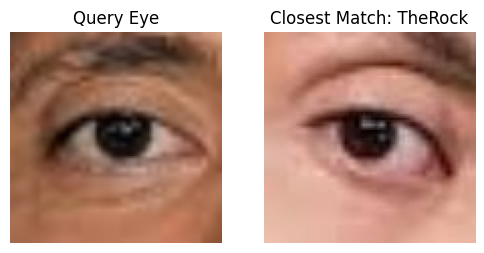

Rock1.jpg → Identified as: Unknown with confidence 74.14%


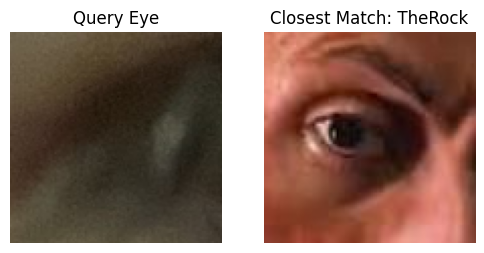

Test1.jpg → Identified as: Unknown with confidence 72.98%


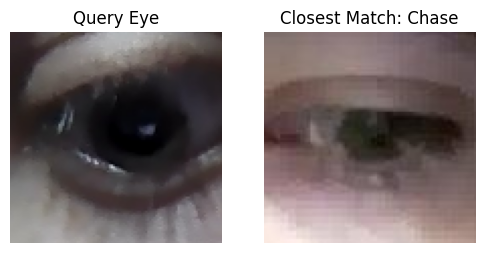

Test10.jpg → Identified as: Unknown with confidence 65.03%


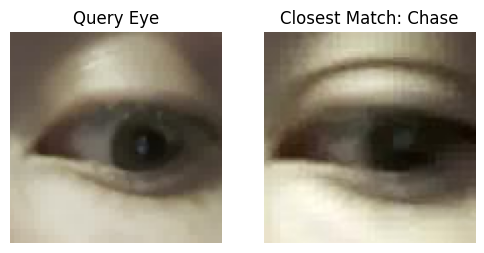

Test2.jpg → Identified as: Chase with confidence 83.00%
No eye detected in query image.
Test3.jpg → Identified as: No eye detected with confidence 0.00%
No eye detected in query image.
Test4.jpg → Identified as: No eye detected with confidence 0.00%
No eye detected in query image.
Test6.jpg → Identified as: No eye detected with confidence 0.00%
No eye detected in query image.
Test7.jpg → Identified as: No eye detected with confidence 0.00%


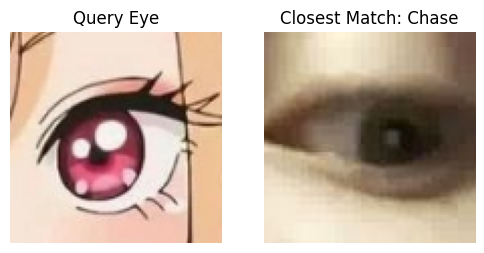

Test8.jpg → Identified as: Unknown with confidence 22.24%


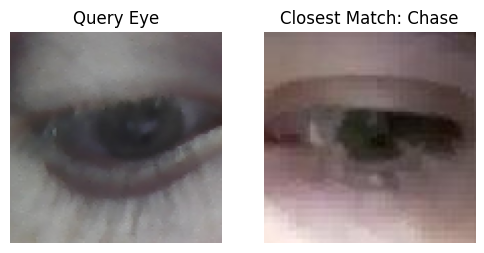

Test9.jpg → Identified as: Unknown with confidence 74.40%


In [ ]:
# -----------------------------
# Paths
# -----------------------------
SAVE_PATH = "siamese_eye_model.keras"
GALLERY_PATH = "Gallery"
TEST_IMAGE_PATH = "TestImages"
EMBEDDING_CACHE = "gallery_embeddings.npy"

# -----------------------------
# Load Siamese model
# -----------------------------
model = load_siamese_model(SAVE_PATH)

# -----------------------------
# Reconstruct base CNN and load weights
# -----------------------------
base_cnn = create_base_cnn((105, 105, 3))

# Copy weights from the trained Siamese model
# In the Siamese model, the base CNN is the 3rd layer (index 2)
# Adjust if your layer ordering differs
for base_layer, siam_layer in zip(base_cnn.layers, model.layers[2].layers):
    base_layer.set_weights(siam_layer.get_weights())

# -----------------------------
# Load gallery
# -----------------------------
gallery_dict = load_gallery_embeddings(GALLERY_PATH)

# -----------------------------
# Compute gallery embeddings (or load cached)
# -----------------------------
gallery_embeddings = compute_gallery_embeddings(
    base_cnn,
    gallery_dict,
    img_size=(105, 105),
    embedding_cache_path=EMBEDDING_CACHE
)

# -----------------------------
# Identify test images
# -----------------------------
for img_name in os.listdir(TEST_IMAGE_PATH):
    if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
        continue
    
    query_image = os.path.join(TEST_IMAGE_PATH, img_name)

    identity, confidence = identify_eye(
        query_image,
        base_cnn,
        gallery_embeddings,
        img_size=(105, 105),
        margin=1.0,
        threshold=70.0
    )

    print(f"{img_name} → Identified as: {identity} with confidence {confidence:.2f}%")
